In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv


In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1')

# Inspect column names and first few rows
print(df.columns)
df.head()



Index(['0', '1467810369', 'Mon Apr 06 22:19:45 PDT 2009', 'NO_QUERY',
       '_TheSpecialOne_',
       '@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D'],
      dtype='object')


,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [3]:
df.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
df.head()

,target,ids,date,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [4]:
import re

def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

# Apply preprocessing
df['text'] = df['text'].apply(preprocess_text)


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Define the feature (X) and target (y) columns
X = df['text']
y = df['target']

# Map target values to a binary classification (0 = negative, 1 = positive)
y = y.map({0: 0, 2: 0, 4: 1})

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Train Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_vectorized, y_train)

# Make predictions and evaluate the model
y_pred = nb_model.predict(X_test_vectorized)
print("Naive Bayes Model Performance")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Naive Bayes Model Performance
Accuracy: 0.768753125
              precision    recall  f1-score   support

           0       0.76      0.78      0.77    159494
           1       0.78      0.76      0.77    160506

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



In [6]:
# Tek seferde tüm veriyi vektörize et
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)


In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad sequences
max_sequence_length = max(len(seq) for seq in X_train_sequences)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length)


In [8]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping

# LSTM modelini oluşturma
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_sequence_length))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

# Modeli derleme
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping tanımlama
early_stopping = EarlyStopping(
    monitor='val_loss',  # İzlenecek metrik
    patience=3,          # Doğrulama kaybı iyileşmediğinde kaç epoch bekleyeceği
    restore_best_weights=True  # En iyi ağırlıkları geri yükle
)

# Modeli eğitme
history = model.fit(
    X_train_padded, y_train,
    epochs=50,  # Eğitim süresini uzatabiliriz çünkü early stopping ile erken durdurma yapılacak
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping]  # Early stopping'i geri çağırmalara ekleyin
)

# Modeli değerlendirme
loss, accuracy = model.evaluate(X_test_padded, y_test)
print("LSTM Model Performansı")
print("Accuracy:", accuracy)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
36000/36000 ━━━━━━━━━━━━━━━━━━━━ 181s 5ms/step - accuracy: 0.7894 - loss: 0.4463 - val_accuracy: 0.8145 - val_loss: 0.4024
Epoch 2/50
36000/36000 ━━━━━━━━━━━━━━━━━━━━ 178s 5ms/step - accuracy: 0.8236 - loss: 0.3885 - val_accuracy: 0.8202 - val_loss: 0.3958
Epoch 3/50
36000/36000 ━━━━━━━━━━━━━━━━━━━━ 179s 5ms/step - accuracy: 0.8336 - loss: 0.3698 - val_accuracy: 0.8214 - val_loss: 0.3924
Epoch 4/50
36000/36000 ━━━━━━━━━━━━━━━━━━━━ 178s 5ms/step - accuracy: 0.8414 - loss: 0.3562 - val_accuracy: 0.8216 - val_loss: 0.3958
Epoch 5/50
36000/36000 ━━━━━━━━━━━━━━━━━━━━ 179s 5ms/step - accuracy: 0.8488 - loss: 0.3429 - val_accuracy: 0.8199 - val_loss: 0.3975
Epoch 6/50
36000/36000 ━━━━━━━━━━━━━━━━━━━━ 179s 5ms/step - accuracy: 0.8559 - loss: 0.3292 - val_accuracy: 0.8189 - val_loss: 0.4045
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.8211 - loss: 0.3930
LSTM Model Performansı
Accuracy: 0.8217625021934509


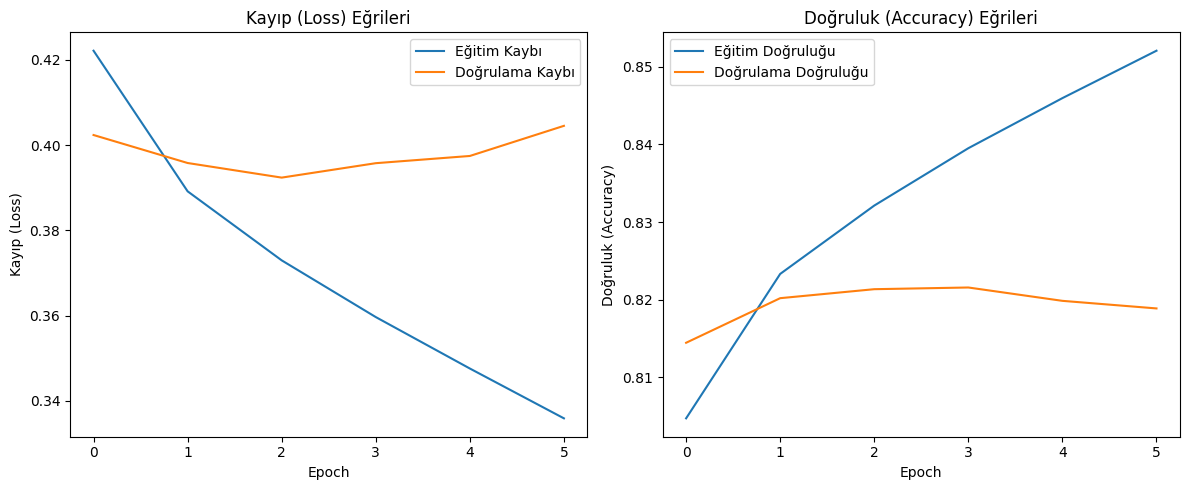

In [9]:
import matplotlib.pyplot as plt
# Eğitim ve doğruluk değerlerini çizme
plt.figure(figsize=(12, 5))

# Kayıp (loss) grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Kayıp (Loss) Eğrileri')
plt.xlabel('Epoch')
plt.ylabel('Kayıp (Loss)')
plt.legend()

# Doğruluk (accuracy) grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Doğruluk (Accuracy) Eğrileri')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk (Accuracy)')
plt.legend()

plt.tight_layout()
plt.show()